# 応用: 周期性のある日単位データの分析

トレンド成分・周期成分がともに入った、**基本構造時系列モデル** 推定していく。  
xtsによる日付データの取り扱いと、KFASによる実装方法を学ぶ。

In [2]:
# インストール
# install.packages("Nippon")

# Nipponパッケージは使えなくなった
source("https://raw.githubusercontent.com/logics-of-blue/website/master/010_forecast/20190714_R%E8%A8%80%E8%AA%9E%E3%81%AB%E3%81%8A%E3%81%91%E3%82%8B%E6%97%A5%E6%9C%AC%E3%81%AE%E7%A5%9D%E6%97%A5%E5%88%A4%E5%AE%9A/jholiday.R", encoding="utf-8")

In [4]:
# パッケージの読み込み
library(KFAS)
library(xts)
# library(Nippon)
library(ggplot2)
library(ggfortify)
library(gridExtra)

# 図示設定
library(repr)
# グラフのオプション
options(repr.plot.width=14, repr.plot.height=6)

In [8]:
# データの読み込み
file_data <- read.csv("book-tsa-ssm-foundation/book-data/5-11-sales_data.csv")
head(file_data, n=3)

,date,sales
,<chr>,<int>
1,2010-03-01,10
2,2010-03-02,34
3,2010-03-03,18


In [10]:
# xts型に変換する
sales <- as.xts(read.zoo(file_data))
head(sales, n = 3)

           [,1]
2010-03-01   10
2010-03-02   34
2010-03-03   18

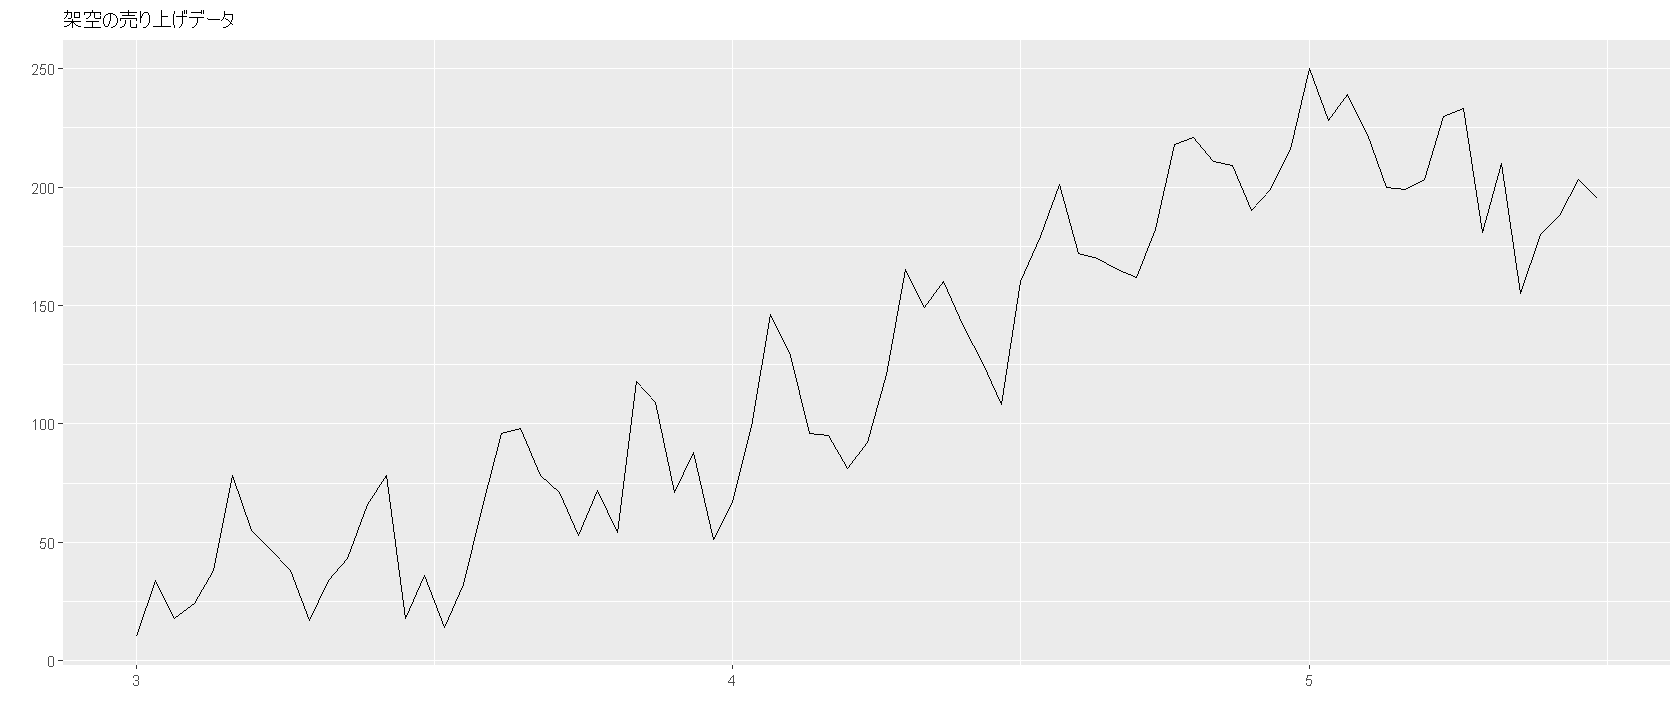

In [12]:
# 図示する
autoplot(sales, main="架空の売り上げデータ")

7日周期で変動していて、トレンドも変化していることがわかる。

## 祝日の取り扱い

日付データを取り扱う場合は、日本固有の暦の影響を神する必要があります。  
xtsとNipponパッケージを組み合わせて使うと処理が簡単。  

In [15]:
# データの日付を取得する
dates <- index(sales)
head(dates, n=5)

[1] "2010-03-01" "2010-03-02" "2010-03-03" "2010-03-04" "2010-03-05"

In [16]:
# 祝日か否かを判別することができる
head(is.jholiday(dates))

[1] FALSE FALSE FALSE FALSE FALSE FALSE

In [17]:
# 祝日だけを抽出する
dates[is.jholiday(dates)]

[1] "2010-03-21" "2010-03-22" "2010-04-29" "2010-05-03" "2010-05-04"
[6] "2010-05-05"

2010-03-21 2010-03-22に祝日になっている。これはおかしい？確認してみる

In [19]:
# 曜日をチェックする
weekdays(dates[is.jholiday(dates)], T)

[1] "日" "月" "木" "月" "火" "水"

2010-03-21(日) 2010-03-22(月)だということで、2010-03-22（月）は振替休日だったことがわかる。  
**日曜日が祝日になったところで、売り上げに影響は無いように思えるので日曜日以外の祝日だけを対象にする**

In [20]:
holiday_date <-
    dates[is.jholiday(dates) & (weekdays(dates, T) != "日")]
print(holiday_date)

[1] "2010-03-22" "2010-04-29" "2010-05-03" "2010-05-04" "2010-05-05"


**土曜日の祝日は影響があるとみなすかどうか、機械的には決めにくいので注意すること。**

In [22]:
# 祝日だった場合は 1, それ以外の日は 0 とするフラグを作成する
holiday_flg <- as.numeric(dates %in% holiday_date)
print(holiday_flg)

 [1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
[39] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0
[77] 0


## KFASによる基本構造時系列モデル

In [25]:
# Step1: モデルの構造を決める
build_cycle <- SSModel(
    H = NA,
    as.numeric(sales) ~
        SSMtrend(degree = 2, c(list(NA), list(NA))) +
        SSMseasonal(period = 7, sea.type = "dummy", Q = NA) +
        holiday_flg
)

In [27]:
# Step2: パラメタ推定
fit_cycle <- fitSSM(build_cycle, inits=c(1,1,1,1))

# Step3,4: フィルタリング・スムージング
result_cycle <- KFS(
    fit_cycle$model,
    filtering = c("state", "mean"),
    smoothing = c("state", "mean")
)

## 推定結果の確認

元データを「トレンド＋水準」の要素と「周期成分」の要素に分けて図示＾する

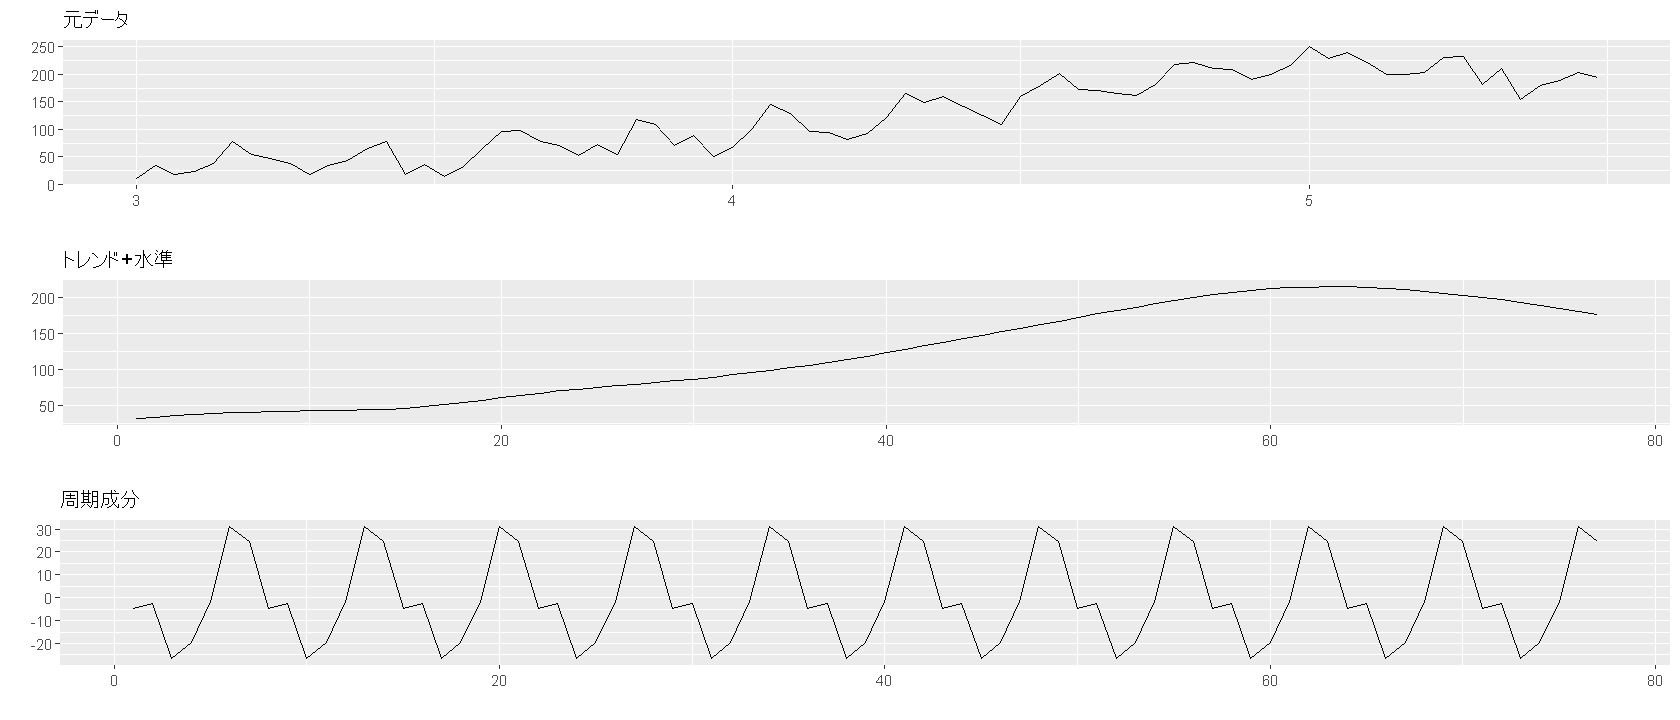

In [30]:
p_data <- autoplot(sales, main = "元データ")
p_trend <- autoplot(result_cycle$alphahat[, "level"], main="トレンド+水準")
p_cycle <- autoplot(result_cycle$alphahat[, "sea_dummy1"], main="周期成分")
grid.arrange(p_data, p_trend, p_cycle)

## 推定結果の図示

In [31]:
# 予測区間
interval_cycle <- predict(
    fit_cycle$model, interval="prediction", level=0.95
)

# データを整形
df <- cbind(
    data.frame(sales = as.numeric(sales),time = as.POSIXct(index(sales))),
    as.data.frame(interval_cycle)
)

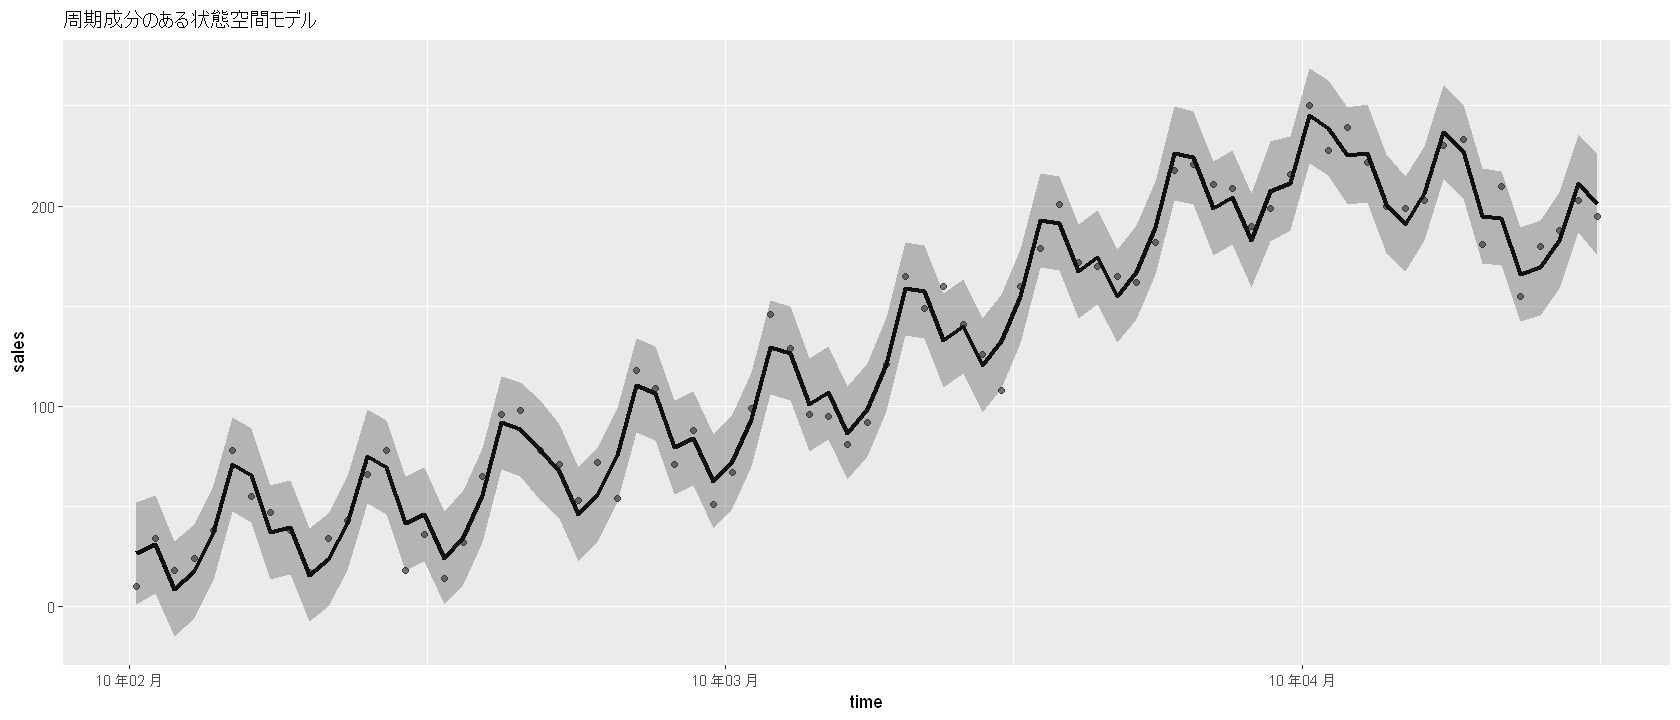

In [33]:
# 図示
ggplot(data = df, aes(x = time, y = sales)) +
labs(title = "周期成分のある状態空間モデル") +
geom_point(alpha = 0.5) +
geom_line(aes(y = fit), size = 1.2) +
geom_ribbon(aes(ymin = lwr, ymax = upr), alpha = 0.3) + 
scale_x_datetime(date_labels = "%y 年%m 月")

## 周期成分を取り除く

周期成分を取り除いた「水準＋トレンド」のみを図示することも可能。  

In [36]:
# 予測区間と平滑化状態
interval_level <- predict(
    fit_cycle$model, interval="confidence", level=0.95, states = "level"
)

# データを整形
df_level <- cbind(
    data.frame(sales = as.numeric(sales),time = as.POSIXct(index(sales))),
    as.data.frame(interval_level))


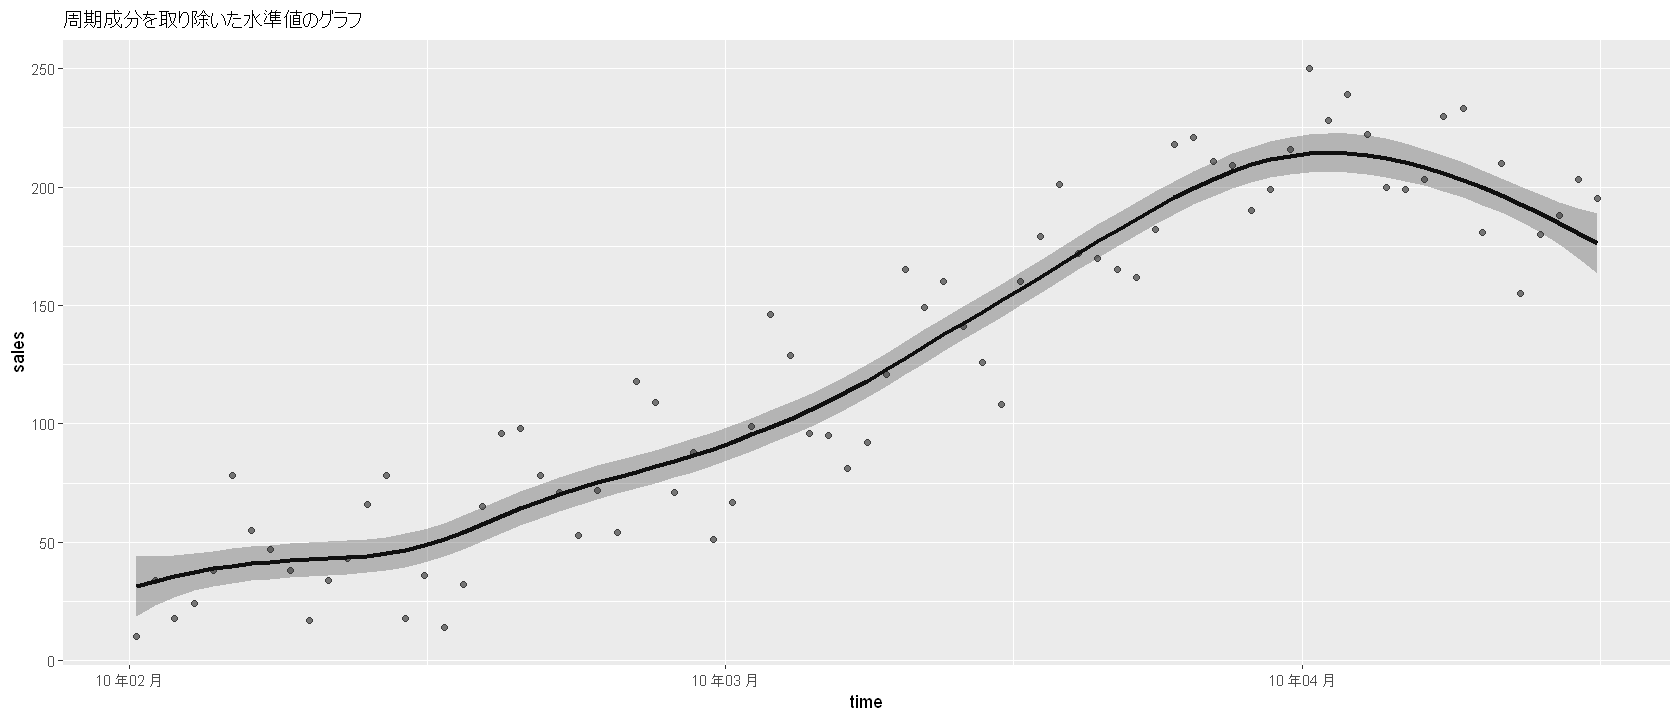

In [37]:
# 図示
ggplot(data = df_level, aes(x = time, y = sales)) +
labs(title = "周期成分を取り除いた水準値のグラフ") +
geom_point(alpha = 0.5) +
geom_line(aes(y = fit), size = 1.2) +
geom_ribbon(aes(ymin = lwr, ymax = upr), alpha = 0.3) + 
scale_x_datetime(date_labels = "%y 年%m 月")